In [1]:
from keras.layers import Input, Conv2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K
import sys
import os
import numpy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras

import PIL.Image

Using TensorFlow backend.


In [2]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

## Problems with the above code

The above code does not create the layers in the correct cases. What we want if the reverse order of VGG19 starting with the last used layer and ending with the first layer of VGG. For instances if we stopped at layer 4 (conv4_1) we will start decoding with conv4_1 and then upsample and make our way though to the beginning of VGG. 

In [3]:
def decoder_layers(inputs, layer):
    
    x = None
    if layer == 5:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
        x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    
    if layer >= 4:
        if x is None:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(inputs)
        else:
            x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
        
    if layer >= 3:
        if x is None:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(inputs)
        else:
            x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)

    if layer >= 2:
        if x is None:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(inputs)
        else:
            x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    
    if layer >= 1:
        if x is None:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(inputs)
        else:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    return x

In [4]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL


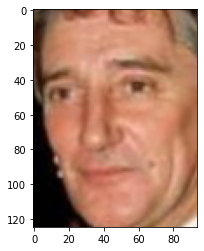

In [5]:
import matplotlib.pyplot as plt 

lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1, color=True)
lfw_people = lfw_people.images
lfw_people = lfw_people.astype('uint8')
plt.imshow(lfw_people[85])

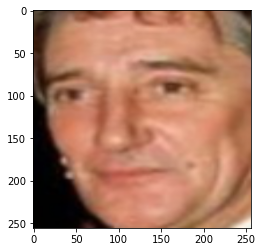

CPU times: user 2.45 s, sys: 740 ms, total: 3.19 s
Wall time: 3.2 s


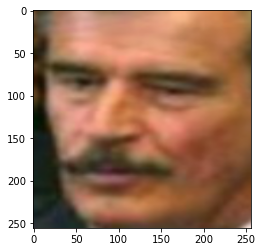

In [6]:
%%time
resized_faces = []
for face in lfw_people:
    img = face.astype('uint8')
    resized_faces.append(cv2.resize(img, dsize=(256,256)))
    
resized_faces = np.array(resized_faces)

img = resized_faces[85].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))
plt.show()

img = resized_faces[86].astype('uint8')
plt.imshow(cv2.resize(img, dsize=(256,256)))

In [7]:
resized_faces = resized_faces.astype('float32') / 255

In [8]:
LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256,256,3), target_layer=5, decoder_path=None, opt='adam'):

        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)
        self.model.add(Conv2D(3, (3, 3), activation='relu', padding='same',
                              name='decoder_out'))
        
        self.loss = self.create_loss_fn(self.encoder)
        
        self.model.compile(optimizer=opt, loss=self.loss)
        
        
    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:], name="decoder_input")
        layers = decoder_layers(inputs, target_layer)
        return Model(inputs, layers, name='decoder_%s' % target_layer)
    
    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)
    def export_model(self):
        self.model.save('./TrainedModels/Block%s_Model/saved_model.pb' % self.target_layer)
    
    def load_decoder(self):
        self.decoder = keras.models.load_model('decoder_%s.h5' % self.target_layer)
        self.decoder.compile('adam', self.loss)
        self.model.compile('adam', self.loss)
    def load_model(self):
        self.model = keras.models.load_model('./TrainedModels/Block%s_Model/saved_model.pb' % self.target_layer, compile=False)
        self.encoder = self.model.layers[0]
        self.decoder = self.model.layers[1]

In [9]:
def plot_history(history, start=0):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)[start:]

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss[start:], 'r', label='Training loss')
    plt.plot(epochs, val_loss[start:], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.show()

#plot_history(history)

In [10]:
# This is from 05c UniversalStyleTransfer.ipynb
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def plot_img_decoder_encoder(img, model):
    input_img = np.asarray(img)
    input_img = cv2.resize(input_img, dsize=(256,256))
    input_img = input_img.reshape(1, 256, 256,3)
    out_sample = model.predict(input_img)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(tensor_to_image(out_sample))
    print(np.mean(np.square(out_sample - input_img)))
    plt.show()

In [11]:
X = resized_faces
y = resized_faces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Train Layer 1

In [14]:
%%time
LAMBDA = 1
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=1, opt=opt)
history = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=180, batch_size=5, verbose=False)

CPU times: user 2h 26s, sys: 1min 16s, total: 2h 1min 42s
Wall time: 2h 58min 59s


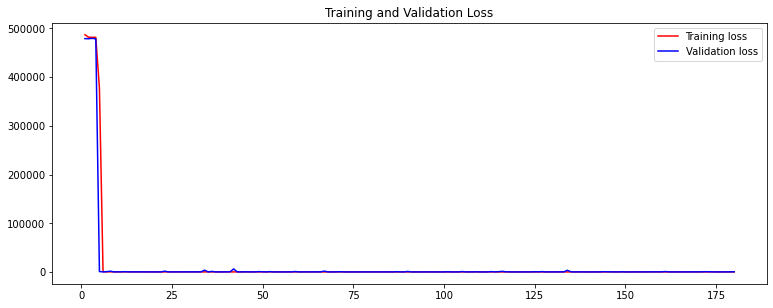

In [15]:
plot_history(history, start=0)

4.0776136e-05


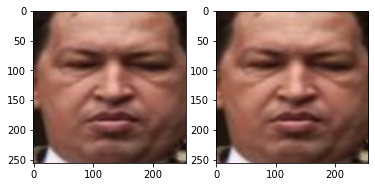

4.037668e-05


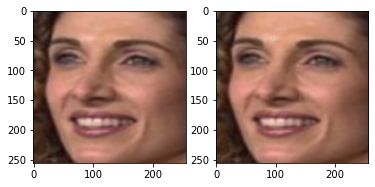

In [16]:
# TODO: Add more recon/decon.
# Including some not faces to talk about features that we lost
plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

In [17]:
encoder_decoder.export_model()

/home/larsen/anaconda3/envs/mlenv2022/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Load the model and show more reconstructions

In [18]:
# TODO

## Train Layer 2

In [15]:
%%time
LAMBDA=1
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
encoder_decoder_2 = EncoderDecoder(input_shape=(256, 256, 3), target_layer=2, opt=opt)
history_2_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=80, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/80
10586/10586 [==============================] - 151s 14ms/step - loss: 3102093.8502 - val_loss: 3045976.5009
Epoch 2/80
10586/10586 [==============================] - 152s 14ms/step - loss: 3071614.0546 - val_loss: 3032023.3320
Epoch 3/80
10586/10586 [==============================] - 152s 14ms/step - loss: 977918.2006 - val_loss: 26663.3272
Epoch 4/80
10586/10586 [==============================] - 153s 14ms/step - loss: 15924.9264 - val_loss: 12541.4228
Epoch 5/80
10586/10586 [==============================] - 152s 14ms/step - loss: 10685.5212 - val_loss: 11848.9385
Epoch 6/80
10586/10586 [==============================] - 151s 14ms/step - loss: 8325.7226 - val_loss: 7226.9690
Epoch 7/80
10586/10586 [==============================] - 151s 14ms/step - loss: 6931.7230 - val_loss: 10622.0087
Epoch 8/80
10586/10586 [==============================] - 152s 14ms/step - loss: 6125.2482 - val_loss: 5923.7447
Epoch 9/80
10586/10586 [===

10586/10586 [==============================] - 151s 14ms/step - loss: 1497.8229 - val_loss: 1264.1061
Epoch 73/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1460.3732 - val_loss: 2777.2146
Epoch 74/80
10586/10586 [==============================] - 153s 14ms/step - loss: 1447.0492 - val_loss: 1507.2020
Epoch 75/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1458.0271 - val_loss: 1642.6388
Epoch 76/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1440.3068 - val_loss: 3617.5295
Epoch 77/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1415.8654 - val_loss: 1886.7398
Epoch 78/80
10586/10586 [==============================] - 153s 14ms/step - loss: 1427.1392 - val_loss: 2329.8443
Epoch 79/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1420.9414 - val_loss: 1810.0485
Epoch 80/80
10586/10586 [==============================] - 152s 14ms/step - loss: 1410.0791 - val_lo

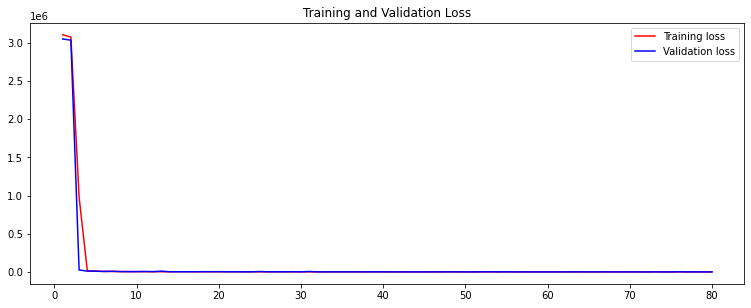

In [16]:
plot_history(history_2_2, start=0)

In [17]:
%%time
LAMBDA=1
history_2_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=40, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1378.2973 - val_loss: 1276.4079
Epoch 2/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1414.0430 - val_loss: 1540.5770
Epoch 3/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1390.0789 - val_loss: 3021.6800
Epoch 4/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1354.8985 - val_loss: 1932.7364
Epoch 5/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1347.6800 - val_loss: 1388.4697
Epoch 6/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1358.9475 - val_loss: 1402.4111
Epoch 7/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1353.6345 - val_loss: 1199.9313
Epoch 8/40
10586/10586 [==============================] - 152s 14ms/step - loss: 1323.0667 - val_loss: 1642.5450
Epoch 9/40
10586/10586 [=======================

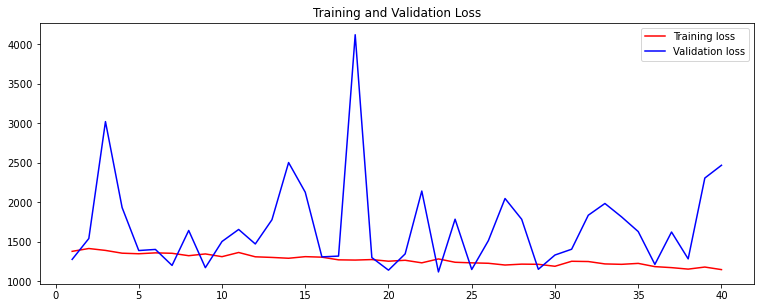

In [18]:
plot_history(history_2_2, start=0)

4.192433e-05


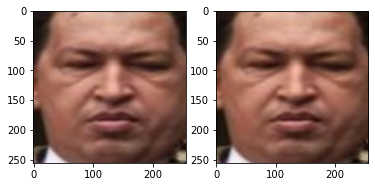

4.405079e-05


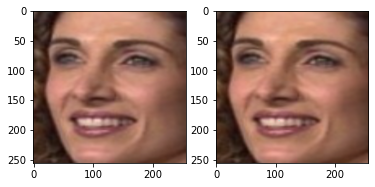

In [19]:
# TODO: Add more recon/decon.
# Including some not faces to talk about features that we lost
plot_img_decoder_encoder(resized_faces[80], encoder_decoder_2.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_2.model)

In [24]:
%%time
LAMBDA=1
history_2_2 = encoder_decoder_2.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=40, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/40
10586/10586 [==============================] - 151s 14ms/step - loss: 1158.0306 - val_loss: 1723.4192
Epoch 2/40
10586/10586 [==============================] - 151s 14ms/step - loss: 1141.8916 - val_loss: 1455.6521
Epoch 3/40
10586/10586 [==============================] - 150s 14ms/step - loss: 1147.8937 - val_loss: 1336.0721
Epoch 4/40
10586/10586 [==============================] - 151s 14ms/step - loss: 1132.2952 - val_loss: 1026.3633
Epoch 5/40
10586/10586 [==============================] - 151s 14ms/step - loss: 1139.9684 - val_loss: 1179.9971
Epoch 6/40
10586/10586 [==============================] - 150s 14ms/step - loss: 1129.8462 - val_loss: 1028.6005
Epoch 7/40
10586/10586 [==============================] - 150s 14ms/step - loss: 1110.3298 - val_loss: 1195.7588
Epoch 8/40
10586/10586 [==============================] - 150s 14ms/step - loss: 1123.5308 - val_loss: 1313.1096
Epoch 9/40
10586/10586 [=======================

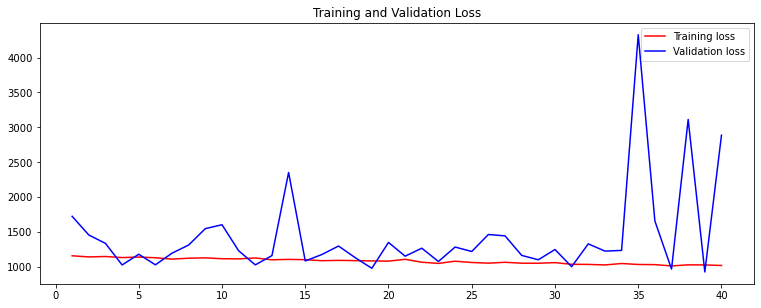

In [25]:
plot_history(history_2_2, start=0)

In [29]:
encoder_decoder_2.export_model()

0.00014608962


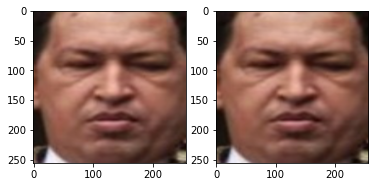

0.00015582822


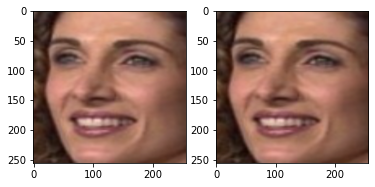

In [30]:

plot_img_decoder_encoder(resized_faces[80], encoder_decoder_2.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder_2.model)

## Train Layer 3

In [31]:
%%time
LAMBDA=1
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
encoder_decoder = EncoderDecoder(input_shape=(256, 256, 3), target_layer=3, opt=opt)
history = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=200, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/200
10586/10586 [==============================] - 210s 20ms/step - loss: 3610745.5724 - val_loss: 3338983.5040
Epoch 2/200
10586/10586 [==============================] - 210s 20ms/step - loss: 3337598.9289 - val_loss: 3289529.8797
Epoch 3/200
10586/10586 [==============================] - 209s 20ms/step - loss: 3300546.5262 - val_loss: 3278670.8069
Epoch 4/200
10586/10586 [==============================] - 210s 20ms/step - loss: 3279747.0560 - val_loss: 3253877.6840
Epoch 5/200
10586/10586 [==============================] - 210s 20ms/step - loss: 2935292.6480 - val_loss: 1747623.6829
Epoch 6/200
10586/10586 [==============================] - 210s 20ms/step - loss: 1693718.8721 - val_loss: 1631272.0047
Epoch 7/200
10586/10586 [==============================] - 210s 20ms/step - loss: 290718.5950 - val_loss: 69762.7891
Epoch 8/200
10586/10586 [==============================] - 210s 20ms/step - loss: 62615.9110 - val_loss: 60488.705

10586/10586 [==============================] - 210s 20ms/step - loss: 16171.3451 - val_loss: 16694.5299
Epoch 71/200
10586/10586 [==============================] - 210s 20ms/step - loss: 16083.8186 - val_loss: 18715.9812
Epoch 72/200
10586/10586 [==============================] - 210s 20ms/step - loss: 16074.8486 - val_loss: 16480.0207
Epoch 73/200
10586/10586 [==============================] - 210s 20ms/step - loss: 15963.0677 - val_loss: 19886.6738
Epoch 74/200
10586/10586 [==============================] - 210s 20ms/step - loss: 15954.2992 - val_loss: 18461.6588
Epoch 75/200
10586/10586 [==============================] - 210s 20ms/step - loss: 15885.4396 - val_loss: 17850.2053
Epoch 76/200
10586/10586 [==============================] - 210s 20ms/step - loss: 15804.5903 - val_loss: 19667.7626
Epoch 77/200
10586/10586 [==============================] - 209s 20ms/step - loss: 15695.0402 - val_loss: 16275.2422
Epoch 78/200
10586/10586 [==============================] - 209s 20ms/step - 

Epoch 140/200
10586/10586 [==============================] - 209s 20ms/step - loss: 13169.5309 - val_loss: 14344.4602
Epoch 141/200
10586/10586 [==============================] - 210s 20ms/step - loss: 13136.5385 - val_loss: 14424.7226
Epoch 142/200
10586/10586 [==============================] - 209s 20ms/step - loss: 13108.4419 - val_loss: 13745.1511
Epoch 143/200
10586/10586 [==============================] - 210s 20ms/step - loss: 13103.5915 - val_loss: 14887.6680
Epoch 144/200
10586/10586 [==============================] - 210s 20ms/step - loss: 13053.9855 - val_loss: 15067.9518
Epoch 145/200
10586/10586 [==============================] - 210s 20ms/step - loss: 13048.9967 - val_loss: 14479.3910
Epoch 146/200
10586/10586 [==============================] - 210s 20ms/step - loss: 13012.2222 - val_loss: 14490.4149
Epoch 147/200
10586/10586 [==============================] - 210s 20ms/step - loss: 12992.9405 - val_loss: 14056.5959
Epoch 148/200
10586/10586 [=============================

0.00018599909


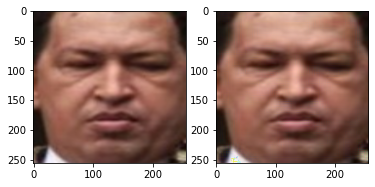

0.00021469721


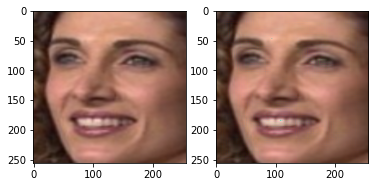

In [32]:
# TODO: Add more recon/decon.
# Including some not faces to talk about features that we lost
plot_img_decoder_encoder(resized_faces[80], encoder_decoder.model)

plot_img_decoder_encoder(resized_faces[81], encoder_decoder.model)

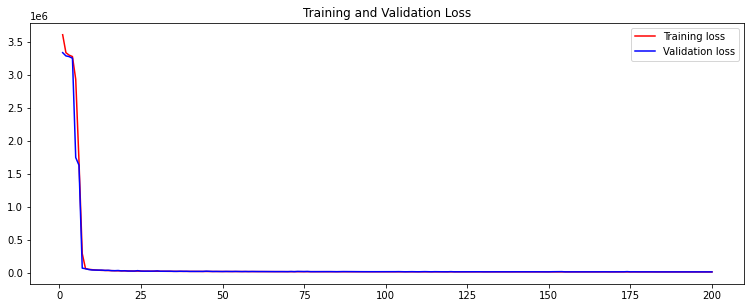

In [33]:
plot_history(history, start=0)

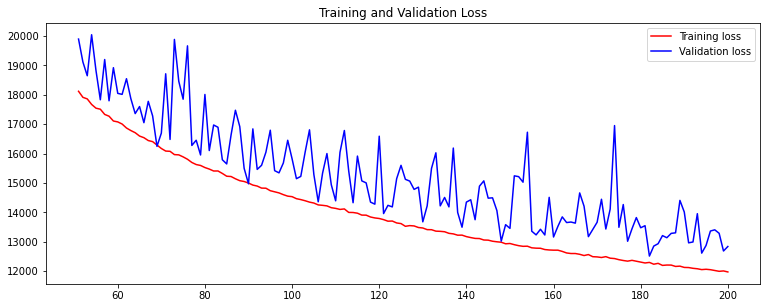

In [34]:
plot_history(history, start=50)

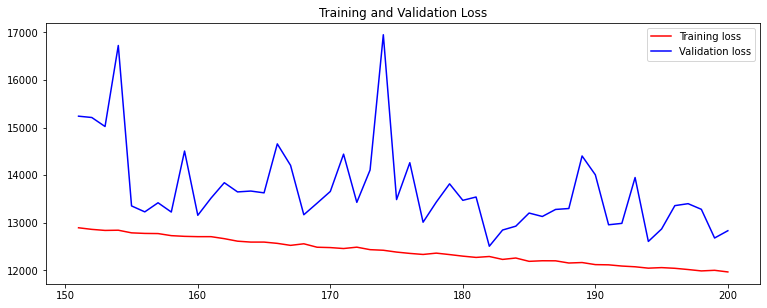

In [35]:
plot_history(history, start=150)

## This has not yet converged, we will run another 100 ephocs

In [37]:

history = encoder_decoder.model.fit(X_train, y_train, 
                                    validation_data=(X_test, y_test),
                                    epochs=200, batch_size=5, verbose=True)

Train on 10586 samples, validate on 2647 samples
Epoch 1/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11984.6474 - val_loss: 13281.6957
Epoch 2/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11940.1325 - val_loss: 12163.6855
Epoch 3/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11918.1155 - val_loss: 12911.6010
Epoch 4/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11925.9930 - val_loss: 13099.4652
Epoch 5/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11904.3438 - val_loss: 13620.5174
Epoch 6/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11917.0168 - val_loss: 12607.1470
Epoch 7/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11840.7683 - val_loss: 13574.9692
Epoch 8/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11858.1659 - val_loss: 13221.0951
Epoch 9/200
10586/10586

10586/10586 [==============================] - 210s 20ms/step - loss: 11127.5392 - val_loss: 12083.5921
Epoch 71/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11139.8813 - val_loss: 11936.5185
Epoch 72/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11116.0512 - val_loss: 12022.5669
Epoch 73/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11089.0199 - val_loss: 12057.4652
Epoch 74/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11103.9210 - val_loss: 11791.2860
Epoch 75/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11082.3962 - val_loss: 12165.2033
Epoch 76/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11089.3200 - val_loss: 12151.4593
Epoch 77/200
10586/10586 [==============================] - 210s 20ms/step - loss: 11064.6332 - val_loss: 12623.1167
Epoch 78/200
10586/10586 [==============================] - 210s 20ms/step - 

Epoch 140/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10607.5414 - val_loss: 12249.2561
Epoch 141/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10620.2140 - val_loss: 12564.6845
Epoch 142/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10575.9151 - val_loss: 11678.3770
Epoch 143/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10613.8201 - val_loss: 11474.5737
Epoch 144/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10545.8035 - val_loss: 11983.1993
Epoch 145/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10569.0315 - val_loss: 11503.2520
Epoch 146/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10541.3876 - val_loss: 12981.8154
Epoch 147/200
10586/10586 [==============================] - 210s 20ms/step - loss: 10579.3007 - val_loss: 11361.3388
Epoch 148/200
10586/10586 [=============================

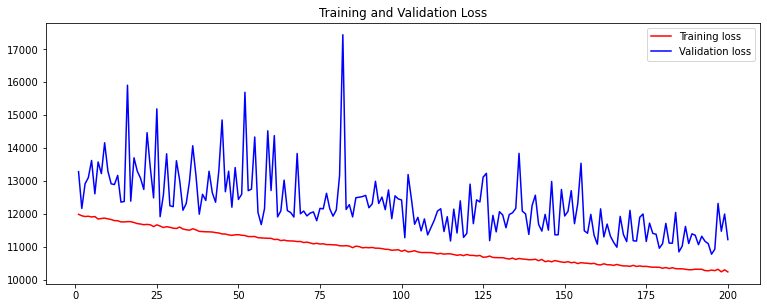

In [39]:
plot_history(history)

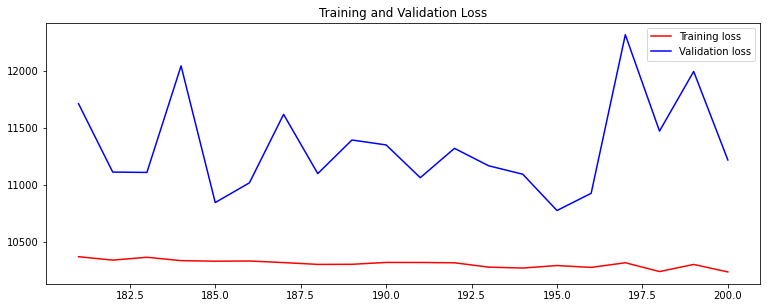

In [42]:
plot_history(history, start = 180)

In [43]:
encoder_decoder.export_model()